# test notebook to read data from h5

In [1]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd         # pandas tabular DataFrame for task/behavioral data
import matplotlib as mpl    # plot
import matplotlib.pyplot as plt
import sklean
import re                   # regular expression
import time                 # time code execution
import pickle
import warnings
import h5py

import dg2df                # for DLSH dynamic group (behavioral data)
import neo                  # data structure for neural data
import quantities as pq
import signal_align         # in this package: align neural data according to task
import PyNeuroAna as pna    # in this package: analysis
import PyNeuroPlot as pnp   # in this package: plot
import misc_tools           # in this package: misc

import data_load_DLSH       # package specific for DLSH lab data


/shared/homes/sguan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class DataNeural(dict):
    def __init__(self, data_dict):
        for (key, value) in data_dict.items():
            self[key] = value
#temp0=DataNeural(temp)

signal_info_detail = pd.read_pickle('/shared/homes/sguan/Coding_Projects/support_data/spike_wf_info_Dante.pkl')
def set_signal_id(signal_info):
    signal_info['signal_id'] = signal_info['date'].apply(lambda x: '{:0>6}'.format(x)).str.cat(
        [signal_info['channel_index'].apply(lambda x: '{:0>2}'.format(x)),
        signal_info['sort_code'].apply(lambda x: '{:0>1}'.format(x))],
        sep='_'
        )
    return signal_info
signal_info_detail = set_signal_id(signal_info_detail)


dir_data_save = '/shared/homes/sguan/Coding_Projects/support_data'
block_type = 'srv_mask'   # one of ['srv_mask', 'matchnot']
signal_type = 'spk'

hdf_file_path = '{}/all_data_dante_{}.hdf5'.format(dir_data_save, 'srv_mask')
hf_srv_mask = h5py.File(hdf_file_path, 'r')

hdf_file_path = '{}/all_data_dante_{}.hdf5'.format(dir_data_save, 'matchnot')
hf_matchnot = h5py.File(hdf_file_path, 'r')


In [3]:
list_psth_srv_mask = []
list_signal_srv_mask = []
list_psth_matchnot = []
list_signal_matchnot = []
list_data_neuro = []
for date in list(hf_srv_mask.keys()):
    print(date, 'reading_dg, srv_mask')
    data_df_srv_mask = pd.read_json(hf_srv_mask[date]['trial_info_json'][()])
    data_df_srv_mask.sort_index(inplace=True)  #  critical!, json makes pandas DataFrame index out of order
    
    print(date, 'reading_neural, srv_mask')
    data_neural_srv_mask = dict([])
    data_neural_srv_mask['data'] = hf_srv_mask[date][signal_type]['data'][:]
    data_neural_srv_mask['ts'] = hf_srv_mask[date][signal_type]['ts'][:]
    data_neural_srv_mask['signal_id'] = hf_srv_mask[date][signal_type]['signal_id'][:]
    data_neural_srv_mask['trial_info'] = data_df_srv_mask
    list_data_neuro.append(data_neural_srv_mask)
    data_neural_srv_mask = signal_align.neuro_sort(data_df_srv_mask, grpby=['stim_familiarized','mask_opacity_int'], neuro=data_neural_srv_mask)
    psth_srv_mask = pna.GroupAve(data_neural_srv_mask)
    list_psth_srv_mask.append(psth_srv_mask)
    list_signal_srv_mask.append(data_neural_srv_mask['signal_id'])

# for date in list(hf_matchnot.keys()):
#     print(date, 'reading_dg, matchnot')
#     data_df_matchnot = pd.read_json(hf_matchnot[date]['trial_info_json'][()])
    
#     print(date, 'reading_neural, matchnot')
#     data_neural_matchnot = dict([])
#     data_neural_matchnot['data'] = hf_matchnot[date][signal_type]['data'][:]
#     data_neural_matchnot['ts'] = hf_matchnot[date][signal_type]['ts'][:]
#     data_neural_matchnot['signal_id'] = hf_matchnot[date][signal_type]['signal_id'][:]
#     data_neural_matchnot['trial_info'] = data_df
#     data_neural_matchnot = signal_align.neuro_sort(data_df_matchnot, grpby=['stim_familiarized','mask_opacity_int'], neuro=data_neural_matchnot)
#     psth_matchnot = pna.GroupAve(data_neural_matchnot)
#     list_psth_matchnot.append(psth_matchnot)
#     list_signal_matchnot.append(data_neural_matchnot['signal_id'])
    


161015 reading_dg, srv_mask
161015 reading_neural, srv_mask
161023 reading_dg, srv_mask
161023 reading_neural, srv_mask
161026 reading_dg, srv_mask
161026 reading_neural, srv_mask
161029 reading_dg, srv_mask
161029 reading_neural, srv_mask
161118 reading_dg, srv_mask
161118 reading_neural, srv_mask
161121 reading_dg, srv_mask
161121 reading_neural, srv_mask
161125 reading_dg, srv_mask
161125 reading_neural, srv_mask
161202 reading_dg, srv_mask
161202 reading_neural, srv_mask
161206 reading_dg, srv_mask
161206 reading_neural, srv_mask
161222 reading_dg, srv_mask
161222 reading_neural, srv_mask
161228 reading_dg, srv_mask
161228 reading_neural, srv_mask
170103 reading_dg, srv_mask
170103 reading_neural, srv_mask
170106 reading_dg, srv_mask
170106 reading_neural, srv_mask
170113 reading_dg, srv_mask
170113 reading_neural, srv_mask
170117 reading_dg, srv_mask
170117 reading_neural, srv_mask
170214 reading_dg, srv_mask
170214 reading_neural, srv_mask
170221 reading_dg, srv_mask
170221 readi

In [3]:
import df_ana

for data_neuro in list_data_neuro:
    
    data_neuro = data_neuro
    data_df = data_neuro['trial_info']

    grpby = 'stim_familiarized'
    df_group = df_ana.DfGroupby(data_df, groupby=grpby, tf_aggregate=False)
    for i_signal in range(len(data_neuro['signal_id'])):
        
        signal_name = str(data_neuro['signal_id'][i_signal])
        print(signal_name)
        
        date_cur, ch_cur, sortcode_cur = re.findall('(\d{6})_(\d*)_(\d*)', signal_name)[0]
        ch_cur = int(ch_cur)
        sortcode_cur = int(sortcode_cur)
        
        if int(ch_cur) >32:
        
            h_fig, h_axes = pnp.CreateSubplotFromGroupby(df_group['order'], tf_title=False)
            # plt.gcf().set_size_inches([10, 8])
            tf_legend = True
            for cdtn in df_group['idx']:
                plt.axes(h_axes[cdtn])
                pnp.PsthPlot(data_neuro['data'][:, :, i_signal], ts=data_neuro['ts'],
                             cdtn=data_df['mask_opacity_int'], limit=df_group['idx'][cdtn], sk_std=0.010,
                             tf_legend=tf_legend)
                tf_legend = False
                plt.title(cdtn, fontsize='small')
            plt.suptitle('{}'.format(signal_name))
            plt.show()
            plt.close('all')

NameError: name 'list_data_neuro' is not defined

In [4]:
dict_tc_by_cdtn = dict()
for data_neuro in list_data_neuro:

    data_df = data_neuro['trial_info']
    signal_id = data_neuro['signal_id'].astype('str')

    date_cur, ch_cur, sort_cur = zip(*[re.findall('(\d*)_(\d*)_(\d*)', signal_id_one)[0] for signal_id_one in signal_id])
    date_cur = np.array(date_cur)
    ch_cur = np.array(ch_cur, dtype='int')
    ch_sort = np.array(sort_cur, dtype='int')

    # data_neuro = signal_align.select_signal(data_neuro, indx=ch_cur>32)

    grpby = ['stim_familiarized', 'stim_sname']
    df_group = df_ana.DfGroupby(data_df, groupby=grpby, tf_aggregate=False, tf_linearize=True)

    num_signal = data_neuro['data'].shape[2]
    tc_by_cdtn = np.zeros([6, 10, num_signal])

    for i_signal in range(data_neuro['data'].shape[2]):
        try:
            signal_name = data_neuro['signal_id'][i_signal]
            
            
            h_fig, h_axes = pnp.CreateSubplotFromGroupby(df_group['order'], tf_title=False, figsize=[10,8])
            tf_legend = True
            for cdtn in df_group['idx']:
                plt.axes(h_axes[cdtn])
                pnp.PsthPlot(data_neuro['data'][:, :, i_signal], ts=data_neuro['ts'],
                             cdtn=data_df['mask_opacity_int'], limit=df_group['idx'][cdtn], sk_std=0.010,
                             tf_legend=tf_legend)
                tf_legend = False
                plt.title(cdtn, fontsize='small')
            plt.suptitle('{}'.format(signal_name))
            plt.show()
            plt.close('all')

            x_fam, fr_mean_fam_00 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==0 ) & (data_df['stim_familiarized']==1) , ts=data_neuro['ts'], t_window=[0.050, 0.250])
            x_fam, fr_mean_fam_50 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==50) & (data_df['stim_familiarized']==1) , ts=data_neuro['ts'], t_window=[0.050, 0.250])
            x_fam, fr_mean_fam_70 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==70) & (data_df['stim_familiarized']==1) , ts=data_neuro['ts'], t_window=[0.050, 0.250])
            x_nov, fr_mean_nov_00 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==0 ) & (data_df['stim_familiarized']==0) , ts=data_neuro['ts'], t_window=[0.050, 0.250])
            x_nov, fr_mean_nov_50 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==50) & (data_df['stim_familiarized']==0) , ts=data_neuro['ts'], t_window=[0.050, 0.250])
            x_nov, fr_mean_nov_70 = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], limit=(data_df['mask_opacity_int']==70) & (data_df['stim_familiarized']==0) , ts=data_neuro['ts'], t_window=[0.050, 0.250])
            #x, fr_fam_std = pna.TuningCurve(data_neuro['data'][:, :, i_signal], data_df['stim_sname'], ts=data_neuro['ts'], t_window=[0.050, 0.250], stat_trials='std')

            tc_by_cdtn[0 , :, i_signal] = fr_mean_fam_00
            tc_by_cdtn[1 , :, i_signal] = fr_mean_fam_50
            tc_by_cdtn[2 , :, i_signal] = fr_mean_fam_70
            tc_by_cdtn[3 , :, i_signal] = fr_mean_nov_00
            tc_by_cdtn[4 , :, i_signal] = fr_mean_nov_50
            tc_by_cdtn[5 , :, i_signal] = fr_mean_nov_70
            
            
            r_pearson_fam_50 = sp.stats.pearsonr(fr_mean_fam_00, fr_mean_fam_50)[0]
            r_pearson_fam_70 = sp.stats.pearsonr(fr_mean_fam_00, fr_mean_fam_70)[0]
            r_pearson_nov_50 = sp.stats.pearsonr(fr_mean_nov_00, fr_mean_nov_50)[0]
            r_pearson_nov_70 = sp.stats.pearsonr(fr_mean_nov_00, fr_mean_nov_70)[0]
            
            r_spearman_fam_50 = sp.stats.spearmanr(fr_mean_fam_00, fr_mean_fam_50)[0]
            r_spearman_fam_70 = sp.stats.spearmanr(fr_mean_fam_00, fr_mean_fam_70)[0]
            r_spearman_nov_50 = sp.stats.spearmanr(fr_mean_nov_00, fr_mean_nov_50)[0]
            r_spearman_nov_70 = sp.stats.spearmanr(fr_mean_nov_00, fr_mean_nov_70)[0]
            
            print(x_00,  x_50)
            h_fig, h_axes = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(10, 5))
            plt.axes(h_axes[0])
            plt.plot(fr_mean_fam_00, fr_mean_fam_50, 'o')
            plt.plot(fr_mean_nov_00, fr_mean_nov_50, 'o')
            plt.legend(['r_fam={:.2f}, {:.2f}'.format(r_pearson_fam_50, r_spearman_fam_50), 'r_nov={:.2f}, {:.2f}'.format(r_pearson_nov_50, r_spearman_nov_50)])
            plt.title('50% noise')
            plt.axes(h_axes[1])
            plt.plot(fr_mean_fam_00, fr_mean_fam_70, 'o')
            plt.plot(fr_mean_nov_00, fr_mean_nov_70, 'o')
            plt.legend(['r_fam={:.2f}, {:.2f}'.format(r_pearson_fam_70, r_spearman_fam_70), 'r_nov={:.2f}, {:.2f}'.format(r_pearson_nov_70, r_spearman_nov_70)])
            plt.title('70% noise')
            plt.axis('equal')
            plt.suptitle(signal_name)
            plt.show()
            plt.close()
        except:
            warnings.warn('signal {} can not be processed'.format(signal_name))
    dict_tc_by_cdtn[date_cur[0]] = tc_by_cdtn
                

NameError: name 'list_data_neuro' is not defined

In [5]:
if False:
    with open('/shared/homes/sguan/Coding_Projects/support_data/dante_all_tc_by_cdtn.pkl', 'wb') as f:
        pickle.dump(dict_tc_by_cdtn, f)

In [6]:
signal_info_tc

NameError: name 'signal_info_tc' is not defined

(505, 11) (6, 10, 266)


/shared/homes/sguan/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/shared/homes/sguan/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/shared/homes/sguan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/shared/homes/sguan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/shared/homes/sguan/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


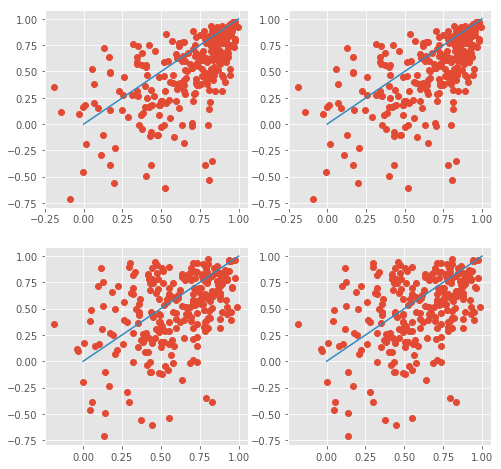

In [148]:
tc_by_cdtn_all = np.concatenate(list(dict_tc_by_cdtn.values()), axis=2)
signal_info_tc = signal_info_detail[signal_info_detail['sort_code']>0]
signal_info_tc.reset_index(inplace=True)

tc_by_cdtn_all = tc_by_cdtn_all[:,:, signal_info_tc['area']!='V4']

num_signal = tc_by_cdtn_all.shape[2]

cdtn_label = [('fam', 0), ('fam', 50), ('fam', 70), ('nov', 0), ('nov', 50), ('nov', 70)]
pearsonr_all = np.zeros(shape=(4, num_signal))
spearmanr_all = np.zeros(shape=(4, num_signal))
index_corr_using_cdtn = {0: (0, 1), 1: (0, 2), 2: (3, 4), 3: (3, 5)}


print(signal_info_tc.shape, tc_by_cdtn_all.shape)

for i_signal in range(num_signal):
    for index_corr, (index0_cdtn, index1_cdtn) in index_corr_using_cdtn.items():
        pearsonr_all[index_corr, i_signal] = sp.stats.pearsonr(tc_by_cdtn_all[index0_cdtn, :, i_signal], 
                                                               tc_by_cdtn_all[index1_cdtn, :, i_signal])[0]
        spearmanr_all[index_corr, i_signal] = sp.stats.spearmanr(tc_by_cdtn_all[index0_cdtn, :, i_signal], 
                                                                 tc_by_cdtn_all[index1_cdtn, :, i_signal])[0]

plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.plot(pearsonr_all[0, :], pearsonr_all[2, :], 'o')
plt.plot([0,1], [0,1])
plt.subplot(2, 2, 2)
plt.plot(pearsonr_all[2, :], pearsonr_all[3, :], 'o')
plt.plot([0,1], [0,1])
plt.subplot(2, 2, 3)
plt.plot(spearmanr_all[0, :], pearsonr_all[1, :], 'o')
plt.plot([0,1], [0,1])
plt.subplot(2, 2, 4)
plt.plot(spearmanr_all[2, :], pearsonr_all[3, :], 'o')
plt.plot([0,1], [0,1])
plt.show()
plt.close()

In [7]:
data_neuro = data_neural_srv_mask
data_df = data_neural_srv_mask['trial_info']

# data_neural = signal_align.neuro_sort(data_df, grpby=['mask_opacity_int'], neuro=data_neuro)、

# psth = pna.GroupAve(data_neural)
# psth_smooth = pna.SmoothTrace(psth, sk_std=0.010, ts=data_neuro['ts'], axis=1)
# print(psth_smooth.shape)

# psth_plot = np.mean(psth_smooth[:, :, 21:22], axis=2)

# plt.plot(psth_plot.transpose())
# plt.show()
# plt.close()


grpby = 'stim_familiarized'
df_group = df_ana.DfGroupby(data_df, groupby=grpby, tf_aggregate=False)

i_signal = -2

signal_name = data_neuro['signal_id'][i_signal]
h_fig, h_axes = pnp.CreateSubplotFromGroupby(df_group['order'], tf_title=False)

tf_legend = True
for cdtn in df_group['idx']:
    plt.axes(h_axes[cdtn])
    pnp.PsthPlot(data_neuro['data'][:, :, i_signal], ts=data_neuro['ts'],
                 cdtn=data_df['mask_opacity_int'], limit=df_group['idx'][cdtn], sk_std=0.010,
                 tf_legend=tf_legend)
    tf_legend = False
    plt.title(cdtn, fontsize='small')
plt.suptitle('{}'.format(signal_name))
plt.show()
plt.close('all')

print(data_neuro['data'].shape, len(data_df))
pnp.PsthPlot(data_neuro['data'][:,:, i_signal], ts=data_neuro['ts'],
                     cdtn=data_df['mask_opacity_int'], limit=data_df['stim_familiarized']==1, sk_std=0.010,
                     tf_legend=True)
plt.title(data_neuro['signal_id'][i_signal])
plt.show()
plt.close()

data_df.index

NameError: name 'data_neural_srv_mask' is not defined

In [8]:
ts_srv_mask = data_neural_srv_mask['ts']
# ts_matchnot = data_neural_matchnot['ts']
signal_srv_mask = np.concatenate(list_signal_srv_mask).astype('str')
# signal_matchnot = np.concatenate(list_signal_matchnot).astype('str')
signal_all = np.unique(np.concatenate(list_signal_srv_mask + list_signal_matchnot).astype('str'))

psth_all_srv_mask = np.concatenate(list_psth_srv_mask, axis=2)
# psth_all_matchnot = np.concatenate(list_psth_matchnot, axis=2)
signal_full_srv_mask = pd.DataFrame({'signal_id': signal_srv_mask}).merge(signal_info_detail, how='inner', on=['signal_id'], copy=False)
# signal_full_matchnot = pd.DataFrame({'signal_id': signal_matchnot}).merge(signal_info_detail, how='inner', on=['signal_id'], copy=False)



psth_all_smooth = pna.SmoothTrace(psth_all_srv_mask, sk_std=0.010, ts=ts_srv_mask, axis=1)
psth_plot = np.mean(psth_all_smooth[:, :, signal_full_srv_mask['area']=='TEm'], axis=2)

print(psth_all_srv_mask.shape, psth_plot.shape, signal_full_srv_mask.shape)

list_color = ['r','r','r','b','b','b']
list_ls = ['-', '-', '-', '--', '--', '--']
list_alpha = [1.0, 0.7, 0.4, 1.0, 0.7, 0.4]

for i in range(6):
    plt.plot(ts_srv_mask, psth_plot[i, :], color=list_color[i], ls = list_ls[i], alpha = list_alpha[i])
plt.show()
plt.close('all')

if False:
    psth_all_smooth = pna.SmoothTrace(psth_all_srv_mask, sk_std=0.020, ts=ts_srv_mask, axis=1)
    psth_plot = psth_all_smooth[2][:, (signal_full_srv_mask['wf_type']=='BS') * (signal_full_srv_mask['area']=='TEd')]
    list_color = pnp.gen_distinct_colors(psth_plot.shape[1])
    for i in range(psth_plot.shape[1]):
        plt.plot(ts_srv_mask, psth_plot[:,i], color=list_color[i])
    plt.title('TEm_BS_by_cells')
    #plt.savefig('./temp_figs/TEm_BS_by_cells')
    plt.show()
    plt.close('all')

NameError: name 'data_neural_srv_mask' is not defined

In [5]:
print(signal_info_detail)

        date   signal_name  channel_index  sort_code  num_spk wf_type  \
0     161015   Chan1 Code1              1          1    33798           
1     161015   Chan1 Code2              1          2     5871           
2     161015   Chan2 Code2              2          2    42438           
3     161015   Chan3 Code0              3          0     5552           
4     161015   Chan4 Code0              4          0     6540           
5     161015   Chan5 Code1              5          1    17848           
6     161015   Chan6 Code0              6          0        1           
7     161015   Chan6 Code1              6          1     8471           
8     161015   Chan7 Code0              7          0     8298           
9     161015   Chan8 Code0              8          0        4           
10    161015   Chan8 Code1              8          1    11336           
11    161015   Chan9 Code0              9          0     7307           
12    161015   Chan9 Code1              9          

In [5]:
date = '161023'
data_df = pd.read_json(hf[date]['trial_info_json'][()])
# data_df = pd.read_hdf(hdf_file_path, '{}/trial_info'.format(date))
data_neural = dict([])
data_neural['data'] = hf[date][signal_type]['data'][:]
data_neural['ts'] = hf[date][signal_type]['ts'][:]
data_neural['signal_id'] = hf[date][signal_type]['signal_id'][:]
data_neural['trial_info'] = data_df

list_date = hf.keys()
list_psth = []
list_signal = []
for date in list_date:
    print(date, 'reading_dg')
    data_df = pd.read_json(hf[date]['trial_info_json'][()])
    # data_df = pd.read_hdf(hdf_file_path, '{}/trial_info'.format(date))
    print(date, 'reading_neural')
    data_neural = dict([])
    data_neural['data'] = hf[date][signal_type]['data'][:]
    data_neural['ts'] = hf[date][signal_type]['ts'][:]
    data_neural['signal_id'] = hf[date][signal_type]['signal_id'][:]
    data_neural['trial_info'] = data_df
    data_neural = signal_align.neuro_sort(data_df, grpby=['stim_familiarized','mask_opacity_int'], neuro=data_neural)
    psth = pna.GroupAve(data_neural)
    list_psth.append(psth)
    list_signal.append(data_neural['signal_id'])

ts = data_neural['ts']
signal_all = np.concatenate(list_signal)
psth_all = np.concatenate(list_psth, axis=2)
signal_full = pd.DataFrame({'signal_id': signal_all}).merge(signal_info_detail, how='inner', on=['signal_id'], copy=False)

psth_all_smooth = pna.SmoothTrace(psth_all, sk_std=0.005, ts=ts, axis=1)
psth_plot = np.mean(psth_all_smooth[:, :, (signal_full['wf_type']=='BS') * (signal_full['area']=='TEm')], axis=2)

list_color = ['r','r','r','b','b','b']
list_ls = ['-', '-', '-', '--', '--', '--']
list_alpha = [1.0, 0.7, 0.4, 1.0, 0.7, 0.4]

for i in range(6):
    plt.plot(ts, psth_plot[i, :], color=list_color[i], ls = list_ls[i], alpha = list_alpha[i])

psth_all_smooth = pna.SmoothTrace(psth_all, sk_std=0.020, ts=ts, axis=1)
psth_plot = psth_all_smooth[2][:, (signal_full['wf_type']=='BS') * (signal_full['area']=='TEm')]
list_color = pnp.gen_distinct_colors(psth_plot.shape[1])
for i in range(psth_plot.shape[1]):
    plt.plot(ts, psth_plot[:,i], color=list_color[i])
plt.title('TEm_BS_by_cells')
#plt.savefig('./temp_figs/TEm_BS_by_cells')
plt.show()
plt.close('all')



NameError: name 'hf' is not defined

In [9]:
ts = data_neural['ts']
signal_all = np.concatenate(list_signal)
psth_all = np.concatenate(list_psth, axis=2)
signal_full = pd.DataFrame({'signal_id': signal_all.astype('str')}).merge(signal_info_detail, how='inner', on=['signal_id'], copy=False)

psth_all_smooth = pna.SmoothTrace(psth_all, sk_std=0.005, ts=ts, axis=1)
psth_plot = np.mean(psth_all_smooth[:, :, (signal_full['wf_type']=='BS') * (signal_full['area']=='TEm')], axis=2)

list_color = ['r','r','r','b','b','b']
list_ls = ['-', '-', '-', '--', '--', '--']
list_alpha = [1.0, 0.7, 0.4, 1.0, 0.7, 0.4]

for i in range(6):
    plt.plot(ts, psth_plot[i, :], color=list_color[i], ls = list_ls[i], alpha = list_alpha[i])

psth_all_smooth = pna.SmoothTrace(psth_all, sk_std=0.020, ts=ts, axis=1)
psth_plot = psth_all_smooth[2][:, (signal_full['wf_type']=='BS') * (signal_full['area']=='TEm')]
list_color = pnp.gen_distinct_colors(psth_plot.shape[1])
for i in range(psth_plot.shape[1]):
    plt.plot(ts, psth_plot[:,i], color=list_color[i])
plt.title('TEm_BS_by_cells')
#plt.savefig('./temp_figs/TEm_BS_by_cells')
plt.show()
plt.close('all')

NameError: name 'data_neural' is not defined

In [68]:
import importlib; importlib.reload(pna)

<module 'PyNeuroAna' from '/shared/homes/sguan/Coding_Projects/PyNeuroSG/PyNeuroAna.py'>

In [20]:
data_neuro['grpby']

['stim_familiarized', 'mask_opacity_int']

In [38]:
re.findall('(\d{6})_(\d*)_(\d*)', str(signal_name))[0]

('170221', '42', '2')

## in-out category tuning

161015 reading_dg, srv_mask
161015 reading_neural, srv_mask
161023 reading_dg, srv_mask
161023 reading_neural, srv_mask
161026 reading_dg, srv_mask
161026 reading_neural, srv_mask
161029 reading_dg, srv_mask
161029 reading_neural, srv_mask
161118 reading_dg, srv_mask
161118 reading_neural, srv_mask
161121 reading_dg, srv_mask
161121 reading_neural, srv_mask
161125 reading_dg, srv_mask
161125 reading_neural, srv_mask
161202 reading_dg, srv_mask
161202 reading_neural, srv_mask
161206 reading_dg, srv_mask
161206 reading_neural, srv_mask
161222 reading_dg, srv_mask
161222 reading_neural, srv_mask
161228 reading_dg, srv_mask
161228 reading_neural, srv_mask
170103 reading_dg, srv_mask
170103 reading_neural, srv_mask
170106 reading_dg, srv_mask
170106 reading_neural, srv_mask
170113 reading_dg, srv_mask
170113 reading_neural, srv_mask
170117 reading_dg, srv_mask
170117 reading_neural, srv_mask
170214 reading_dg, srv_mask
170214 reading_neural, srv_mask
170221 reading_dg, srv_mask
170221 readi

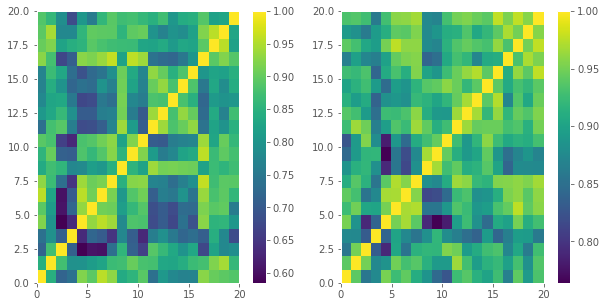

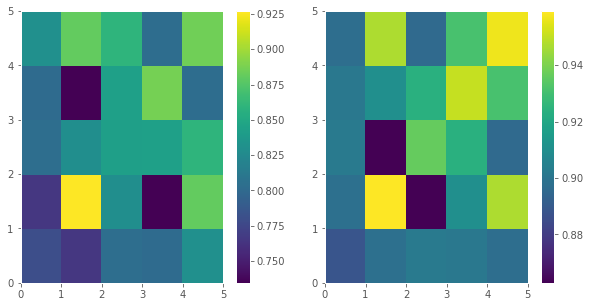

161023 18 0
161026 15 14


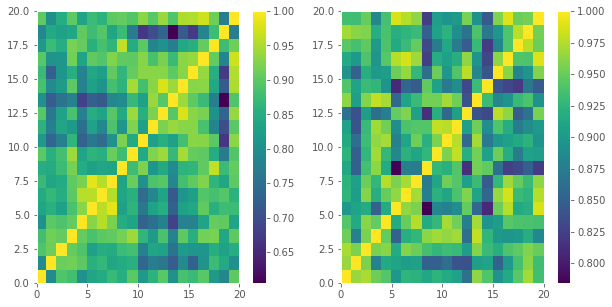

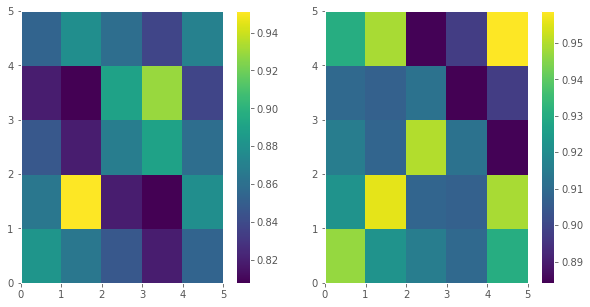

161029 12 23


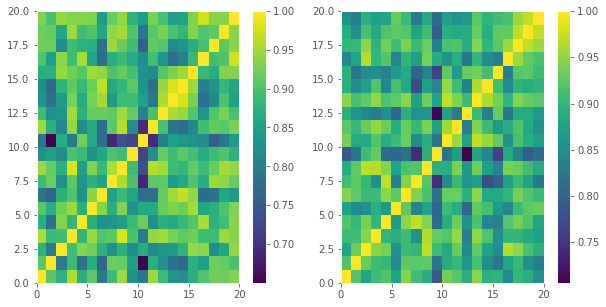

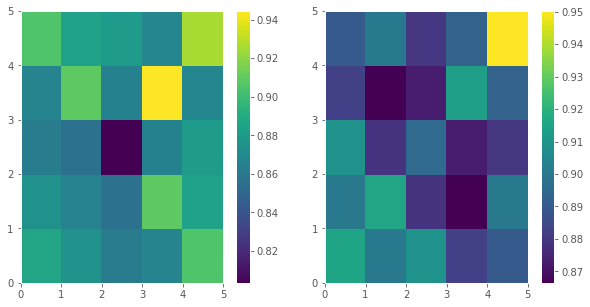

161118 15 16


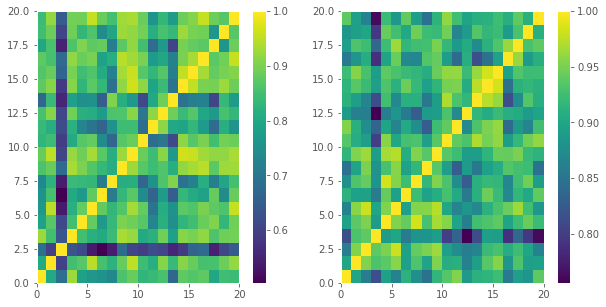

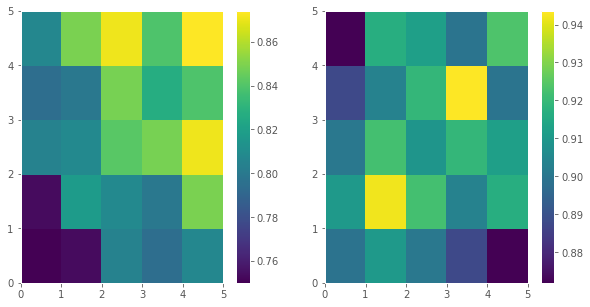

161121 15 13


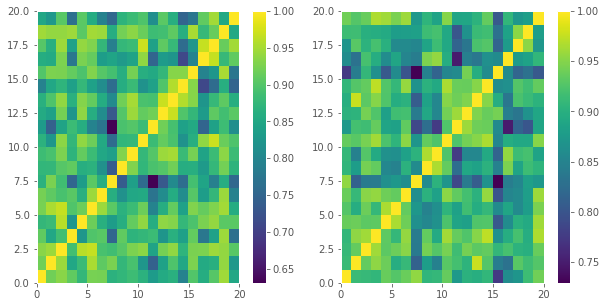

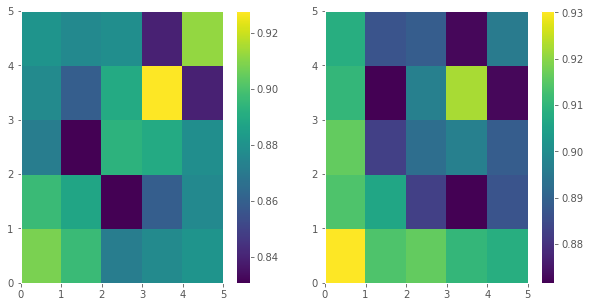

161125 19 18


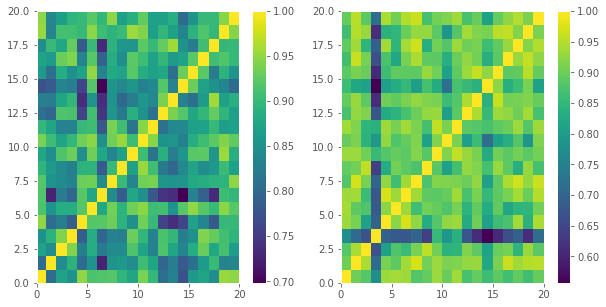

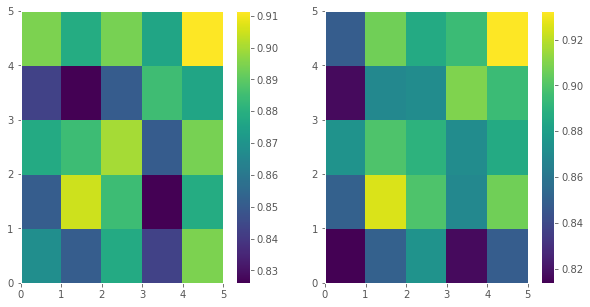

161202 13 14


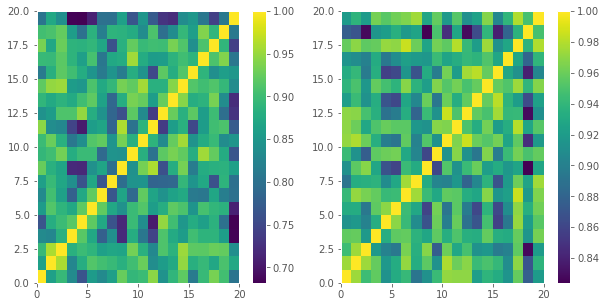

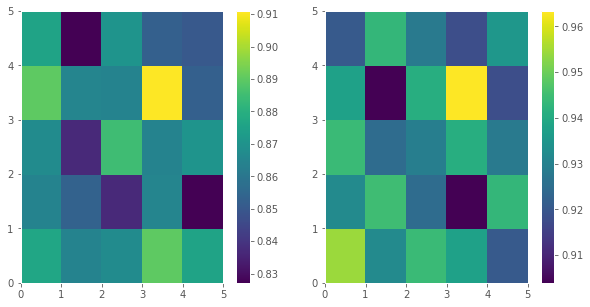

161206 7 23


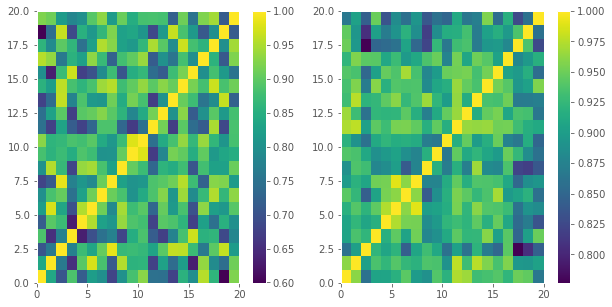

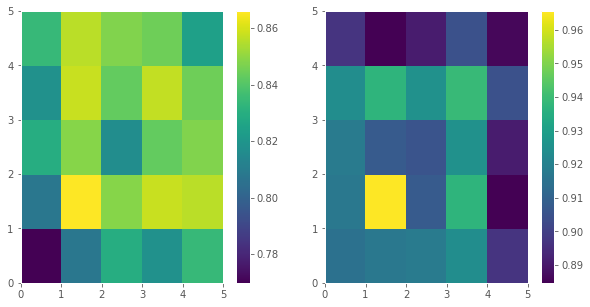

161222 9 15


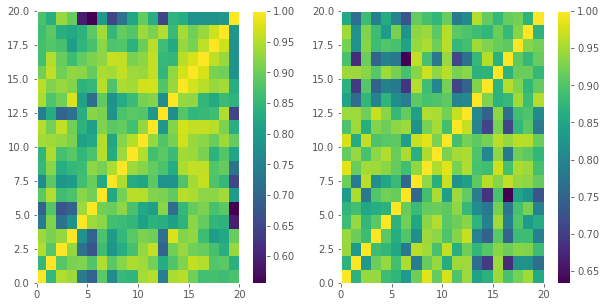

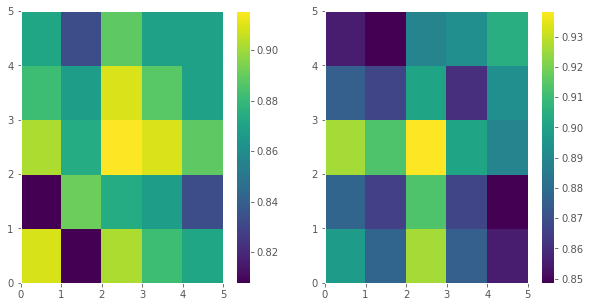

161228 19 21


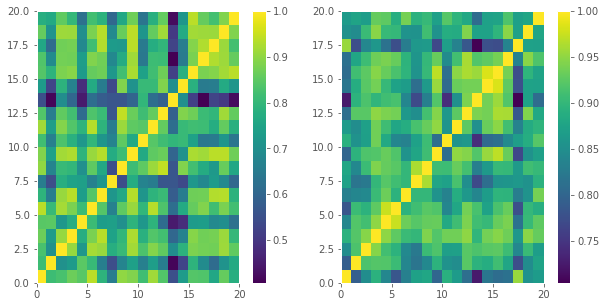

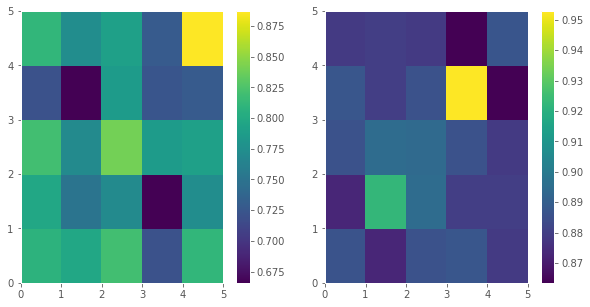

170103 13 23


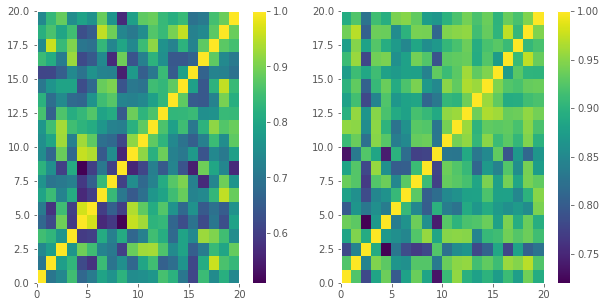

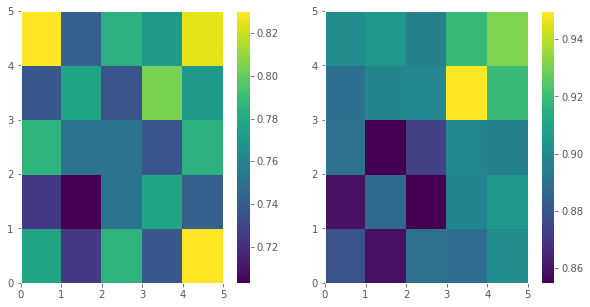

170106 15 9


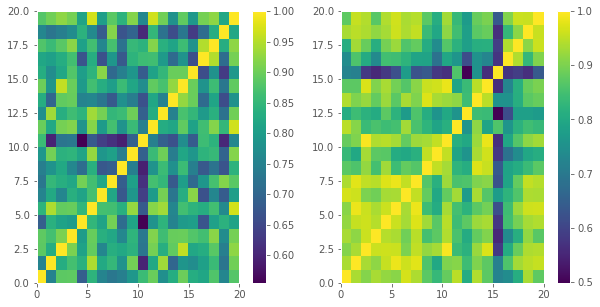

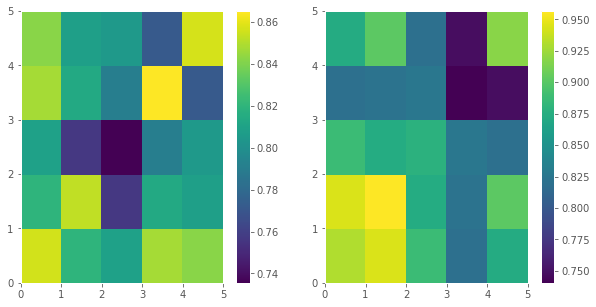

170113 14 22


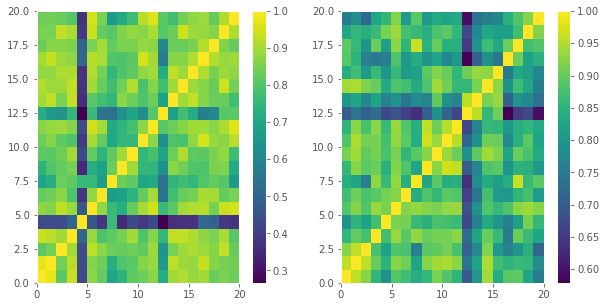

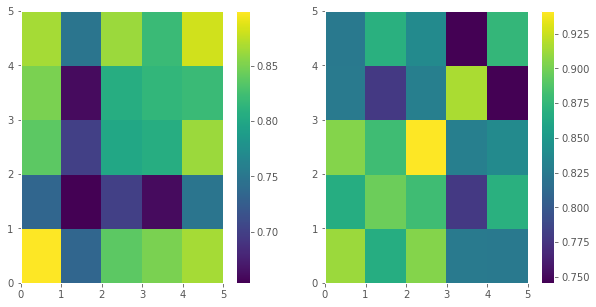

170117 12 15


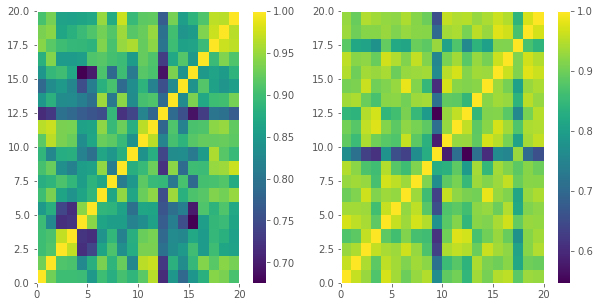

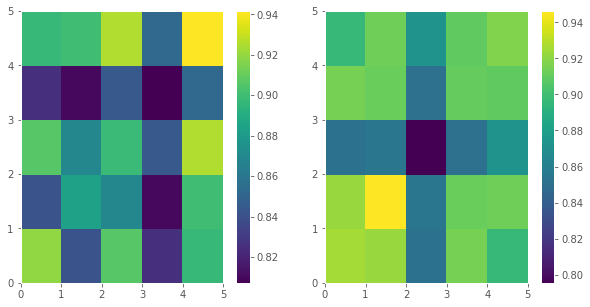

170214 9 12


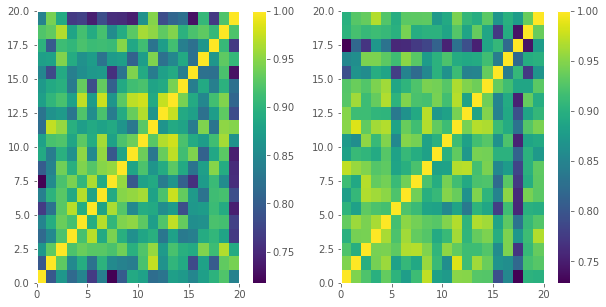

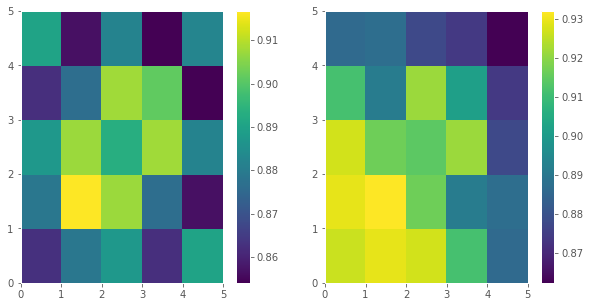

170221 12 11


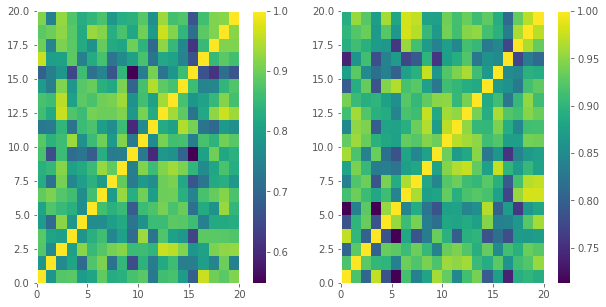

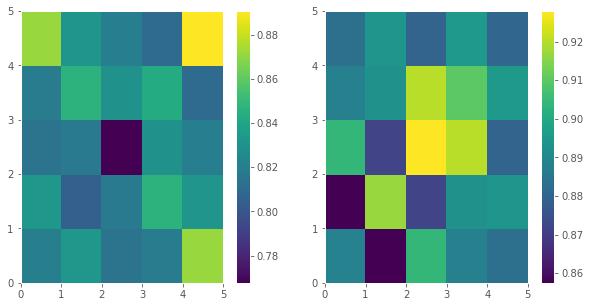

In [181]:
list_sim_matrix_V4 = []
list_sim_matrix_IT = []


def GetSignalInfo(signal_id):
    date_cur, ch_cur, sortcode_cur =  zip(*[re.findall('(\d{6})_(\d*)_(\d*)', signal_name)[0] for signal_name in signal_id.astype('str')])
    return np.array(date_cur), np.array(ch_cur, dtype='int'), np.array(sortcode_cur, dtype='int')

def subregion_average(sim_matrix):
    sim_matrix = sim_matrix + np.diag([np.nan]*20)
    matrix_new = np.zeros([5,5])
    for i in range(5):
        for j in range(5):
            matrix_new[i,j] = np.nanmean(sim_matrix[np.arange(20)//4==i, :][:, np.arange(20)//4==j])
    return matrix_new

for date in list(hf_srv_mask.keys()):
    print(date, 'reading_dg, srv_mask')
    data_df_srv_mask = pd.read_json(hf_srv_mask[date]['trial_info_json'][()])
    data_df_srv_mask.sort_index(inplace=True)  #  critical!, json makes pandas DataFrame index out of order
    
    print(date, 'reading_neural, srv_mask')
    data_neural_srv_mask = dict([])
    data_neural_srv_mask['data'] = hf_srv_mask[date][signal_type]['data'][:]
    data_neural_srv_mask['ts'] = hf_srv_mask[date][signal_type]['ts'][:]
    data_neural_srv_mask['signal_id'] = hf_srv_mask[date][signal_type]['signal_id'][:]
    data_neural_srv_mask['trial_info'] = data_df_srv_mask

for date in list(hf_srv_mask.keys()):
    # print(date, 'reading_dg, srv_mask')
    data_df_srv_mask = pd.read_json(hf_srv_mask[date]['trial_info_json'][()])
    data_df_srv_mask.sort_index(inplace=True)  #  critical!, json makes pandas DataFrame index out of order
    
    # print(date, 'reading_neural, srv_mask')
    data_neural_srv_mask = dict([])
    data_neural_srv_mask['data'] = hf_srv_mask[date][signal_type]['data'][:]
    data_neural_srv_mask['ts'] = hf_srv_mask[date][signal_type]['ts'][:]
    data_neural_srv_mask['signal_id'] = hf_srv_mask[date][signal_type]['signal_id'][:]
    data_neural_srv_mask['trial_info'] = data_df_srv_mask
    
    date, ch, sortcode = GetSignalInfo(data_neural_srv_mask['signal_id'])
    inV4 = (ch<=32)
    inIT = (ch>32)
    print(date[0], inV4.sum(), inIT.sum())
    
    if inV4.sum()<4 or inIT.sum()<4:
        continue
    
    data_neural_srv_mask = signal_align.neuro_sort(data_neural_srv_mask['trial_info'], 
                                                   grpby=['stim_sname', 'stim_familiarized'], 
                                                   fltr=data_neural_srv_mask['trial_info']['mask_opacity_int']==0, 
                                                   neuro=data_neural_srv_mask)
    fr_over_time = pna.GroupStat(data_neural_srv_mask)
    fr = pna.AveOverTime(fr_over_time, t_range=[0.050, 0.200], ts=data_neural_srv_mask['ts'])
    fr_norm = fr / (np.mean(fr, axis=0, keepdims=True) + 5)

    assert fr.shape[0]==20

    sim_matrix_V4_org = sklearn.metrics.pairwise.cosine_similarity(fr_norm[:, inV4])
    sim_matrix_IT_org = sklearn.metrics.pairwise.cosine_similarity(fr_norm[:, inIT])
    sim_matrix_V4 = subregion_average(sim_matrix_V4_org)
    sim_matrix_IT = subregion_average(sim_matrix_IT_org)
    
    
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.pcolormesh(sim_matrix_V4_org)
    plt.colorbar()
    plt.subplot(122)
    plt.pcolormesh(sim_matrix_IT_org)
    plt.colorbar()
    
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.pcolormesh(sim_matrix_V4)
    plt.colorbar()
    plt.subplot(122)
    plt.pcolormesh(sim_matrix_IT)
    plt.colorbar()
    
    plt.show()
    plt.close()
    
    list_sim_matrix_V4.append(sim_matrix_V4)
    list_sim_matrix_IT.append(sim_matrix_IT)


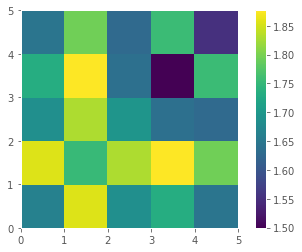

[('bird_fam_4201', 1), ('bird_fam_7036', 1), ('bird_nov_12957', 0), ('bird_nov_14774', 0), ('car_fam_12696', 1), ('car_fam_5735', 1), ('car_nov_11097', 0), ('car_nov_896', 0), ('dog_fam_20087', 1), ('dog_fam_26559', 1), ('dog_nov_1284', 0), ('dog_nov_6002', 0), ('face_fam_17233', 1), ('face_fam_7156', 1), ('face_nov_2883', 0), ('face_nov_3145', 0), ('house_fam_2304', 1), ('house_fam_3480', 1), ('house_nov_12017', 0), ('house_nov_2766', 0)]


In [180]:
plt.pcolormesh(np.mean(np.dstack(list_sim_matrix_V4), axis=2))
plt.axis('image')
plt.colorbar()
plt.show()
plt.close()
print(data_neural_srv_mask['cdtn'])

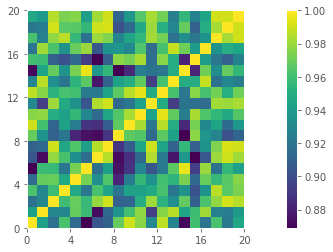

[('bird_fam_4201', 1), ('bird_fam_7036', 1), ('bird_nov_12957', 0), ('bird_nov_14774', 0), ('car_fam_12696', 1), ('car_fam_5735', 1), ('car_nov_11097', 0), ('car_nov_896', 0), ('dog_fam_20087', 1), ('dog_fam_26559', 1), ('dog_nov_1284', 0), ('dog_nov_6002', 0), ('face_fam_17233', 1), ('face_fam_7156', 1), ('face_nov_2883', 0), ('face_nov_3145', 0), ('house_fam_2304', 1), ('house_fam_3480', 1), ('house_nov_12017', 0), ('house_nov_2766', 0)]


In [161]:
import sklearn
temp = sklearn.metrics.pairwise.cosine_similarity(fr[:, inIT])
plt.pcolormesh(temp)
plt.xticks(range(0,21,4))
plt.yticks(range(0,21,4))
plt.colorbar()
plt.axis('image')
plt.axis('square')
plt.show()
plt.close()
print(data_neural_srv_mask['cdtn'])

In [95]:
ch = np.array(pd.Series(data_neural_srv_mask['signal_id'].astype('str')).str.extract('_(.*)_'), dtype=int)
isV4 = (ch<=32)
isIT = (ch>32)


/shared/homes/sguan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


In [60]:
data_neural_srv_mask.keys()

dict_keys(['data', 'ts', 'signal_id', 'trial_info', 'grpby', 'fltr', 'cdtn', 'cdtn_indx'])

In [104]:
def GetSignalInfo(signal_id):
    date_cur, ch_cur, sortcode_cur =  zip(*[re.findall('(\d{6})_(\d*)_(\d*)', signal_name)[0] for signal_name in signal_id.astype('str')])
    return np.array(date_cur), np.array(ch_cur, dtype='int'), np.array(sortcode_cur, dtype='int')

data, ch, sortcode = GetSignalInfo(data_neural_srv_mask['signal_id'])
inV4 = (ch<=32)
inIT = (ch>32)

In [90]:
data_neural_srv_mask['signal_id'].astype('str').shape

(23,)

In [131]:
temp = np.random.rand(5,5)
np.diag(temp)=0
print(temp)

SyntaxError: can't assign to function call (<ipython-input-131-99a2036f64b9>, line 2)

In [133]:
np.diag([np.nan]*5)

array([[nan,  0.,  0.,  0.,  0.],
       [ 0., nan,  0.,  0.,  0.],
       [ 0.,  0., nan,  0.,  0.],
       [ 0.,  0.,  0., nan,  0.],
       [ 0.,  0.,  0.,  0., nan]])

In [128]:
import importlib
importlib.reload(np)

<module 'numpy' from '/shared/homes/sguan/anaconda3/lib/python3.6/site-packages/numpy/__init__.py'>

In [139]:
len(list_data_neuro)

17

In [147]:
len(list_sim_matrix_V4)

1

In [174]:
fr

array([[ 14.29472642,  12.30011343,  14.29472642,   5.31896797,
         44.54635676, 117.68216637,  16.28933941,  30.91650133,
          4.32166148,  17.28664591,   7.64601646,  21.60830738,
          9.97306495,  16.28933941,  19.61369439,  26.26240436,
         10.30550044,   9.64062945,  14.29472642,   6.98114546,
          9.64062945,   8.31088746,  15.62446842,  14.95959742,
          0.        ,   8.64332295,   1.66217749,  15.95690391],
       [  5.31896797,   9.97306495,  14.29472642,   2.99191948,
         15.95690391,  77.45747108,   4.65409697,  16.62177491,
          6.31627447,  15.95690391,   8.31088746,   7.97845196,
          4.32166148,   5.31896797,  11.63524244,  23.60292037,
          7.97845196,  11.63524244,  35.90303381,   6.31627447,
          7.31358096,   6.64870996,   9.97306495,   8.64332295,
          0.        ,   9.30819395,   3.98922598,  14.29472642],
       [  4.98653247,  14.62716192,  14.95959742,  10.30550044,
         35.23816281, 109.37127891,   